In [ ]:
from google.colab import files
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, SimpleRNN
from tensorflow.python.keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



Using TensorFlow backend.


In [ ]:
files.upload()

{}

#Загрузка данных

In [ ]:
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace("\n", " ")
  
  return text

trainText = []
trainText.append(readText('(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('(Стругацкие) Обучающая_5 вместе.txt'))
trainText.append(readText('(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('(Рэй Брэдберри) Обучающая_22 вместе.txt'))                
                 
className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдбери"]  
nClasses = len(className)


testText = []
testText.append(readText('(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('(Стругацкие) Тестовая_2 вместе.txt'))
testText.append(readText('(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('(Рэй Брэдберри) Тестовая_8 вместе.txt'))

In [ ]:
maxWordsCount = 100

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False)

tokenizer.fit_on_texts(trainText)


In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)


In [ ]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  while(index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample
    


In [ ]:
def createSetsMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) #добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  
  xSamples = [] 
  ySamples = [] 
  
  for t in range(nClasses): 
    xT = classesXSamples[t] 
    for i in range(len(xT)): 
      xSamples.append(xT[i]) 
    
    currY = utils.to_categorical(t, nClasses) 
    for i in range(len(xT)): 
      ySamples.append(currY) 

  xSamples = np.array(xSamples) 
  ySamples = np.array(ySamples) 

  
  return (xSamples, ySamples) 

**Подготовка данных**

In [ ]:
xLen = 1000 
step = 100 

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) 
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    


In [ ]:

xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())


##Вариант 1

Train on 7086 samples, validate on 2622 samples
Epoch 1/20
7086/7086 [==============================] - 0s 62us/sample - loss: 1.6085 - acc: 0.4211 - val_loss: 1.9904 - val_acc: 0.3501
Epoch 2/20
7086/7086 [==============================] - 0s 28us/sample - loss: 0.8312 - acc: 0.6997 - val_loss: 1.8350 - val_acc: 0.4027
Epoch 3/20
7086/7086 [==============================] - 0s 27us/sample - loss: 0.6227 - acc: 0.7762 - val_loss: 1.6580 - val_acc: 0.4638
Epoch 4/20
7086/7086 [==============================] - 0s 31us/sample - loss: 0.5011 - acc: 0.8226 - val_loss: 1.4809 - val_acc: 0.5187
Epoch 5/20
7086/7086 [==============================] - 0s 27us/sample - loss: 0.4345 - acc: 0.8460 - val_loss: 1.3059 - val_acc: 0.5713
Epoch 6/20
7086/7086 [==============================] - 0s 29us/sample - loss: 0.3939 - acc: 0.8562 - val_loss: 1.1537 - val_acc: 0.6114
Epoch 7/20
7086/7086 [==============================] - 0s 27us/sample - loss: 0.3477 - acc: 0.8757 - val_loss: 1.0766 - val_acc: 

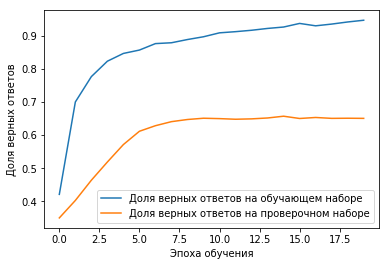

In [ ]:
model01 = Sequential()
model01.add(BatchNormalization())
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
model01.add(Dropout(0.5))
model01.add(BatchNormalization())
model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


history = model01.fit(xTrain01, 
                    yTrain, 
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest01, yTest))

plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  
  nClasses = len(wordIndexes) 
  xTest6Classes01 = []                
  xTest6Classes = []                 
  for wI in wordIndexes:                     
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(np.array(sample))             
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                     
  
  return xTest6Classes01, xTest6Classes  


def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
 
  for i in range(nClasses):
    
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    currOut = np.argmax(currPred, axis=1)
    
    
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
   
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
   
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
 
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
    
  print()
  
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)

In [ ]:
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

О. Генри  распознано  89 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  24 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  57 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  26 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  78 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  97 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  65 %



##Вариант 2

Train on 15779 samples, validate on 5674 samples
Epoch 1/20
15779/15779 [==============================] - 4s 277us/sample - loss: 0.0543 - acc: 0.9831 - val_loss: 0.6881 - val_acc: 0.8722
Epoch 2/20
15779/15779 [==============================] - 4s 252us/sample - loss: 7.3450e-04 - acc: 1.0000 - val_loss: 0.6099 - val_acc: 0.8927
Epoch 3/20
15779/15779 [==============================] - 4s 252us/sample - loss: 4.3721e-04 - acc: 1.0000 - val_loss: 0.4991 - val_acc: 0.9001
Epoch 4/20
15779/15779 [==============================] - 4s 250us/sample - loss: 3.0257e-04 - acc: 1.0000 - val_loss: 0.4149 - val_acc: 0.8990
Epoch 5/20
15779/15779 [==============================] - 4s 253us/sample - loss: 2.2270e-04 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.8983
Epoch 6/20
15779/15779 [==============================] - 4s 248us/sample - loss: 1.7067e-04 - acc: 1.0000 - val_loss: 0.3371 - val_acc: 0.8980
Epoch 7/20
15779/15779 [==============================] - 4s 247us/sample - loss: 1.4191e-0

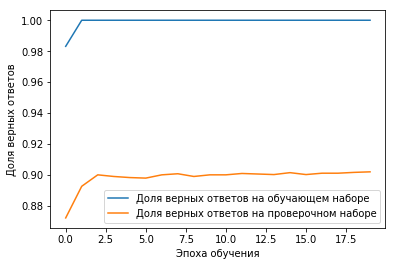

In [ ]:
maxWordsCount = 20000

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False)

tokenizer.fit_on_texts(trainText)

trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  while(index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample
   

def createSetsMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) #добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  
  xSamples = [] 
  ySamples = [] 
  
  for t in range(nClasses): 
    xT = classesXSamples[t] 
    for i in range(len(xT)): 
      xSamples.append(xT[i]) 
    
    currY = utils.to_categorical(t, nClasses) 
    for i in range(len(xT)): 
      ySamples.append(currY) 

  xSamples = np.array(xSamples) 
  ySamples = np.array(ySamples) 

  
  return (xSamples, ySamples) 

xLen = 1000 
step = 100 

xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) 

xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    

xTrain02 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest02 = tokenizer.sequences_to_matrix(xTest.tolist())

model02 = Sequential()
model02.add(BatchNormalization())
model02.add(Dense(200, input_dim=maxWordsCount, activation="linear"))
model02.add(Dropout(0.5))

model02.add(BatchNormalization())
model02.add(Dense(6, activation='softmax'))

model02.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


history2 = model02.fit(xTrain02, 
                    yTrain, 
                    epochs=20,
                    batch_size=200,
                    validation_data=(xTest02, yTest))

plt.plot(history2.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()



In [ ]:
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  
  nClasses = len(wordIndexes) 
  xTest6Classes01 = []                
  xTest6Classes = []                 
  for wI in wordIndexes:                     
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(np.array(sample))             
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                     
  
  return xTest6Classes01, xTest6Classes  


def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
 
  for i in range(nClasses):
    
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    currOut = np.argmax(currPred, axis=1)
    
    
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
   
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
   
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
 
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
    
  print()
  
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)

pred = recognizeMultiClass(model02, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

О. Генри  распознано  99 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  91 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  74 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  88 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  91 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  99 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  90 %



##Вариант 3

In [ ]:
maxWordsCount = 50000

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789', lower=True, split=' ', char_level=False)

tokenizer.fit_on_texts(trainText)


In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  while(index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample
    
def createSetsMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) 

  
  xSamples = [] 
  ySamples = [] 
  
  for t in range(nClasses): 
    xT = classesXSamples[t] 
    for i in range(len(xT)): 
      xSamples.append(xT[i]) 
    
    currY = utils.to_categorical(t, nClasses) 
    for i in range(len(xT)): 
      ySamples.append(currY) 

  xSamples = np.array(xSamples) 
  ySamples = np.array(ySamples) 

  
  return (xSamples, ySamples) 

xLen = 1000 
step = 100 

xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) 
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)  

xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

def createTestMultiClasses(wordIndexes, xLen, step): 

  
  nClasses = len(wordIndexes) 
  xTest6Classes01 = []                
  xTest6Classes = []                 
  for wI in wordIndexes:                     
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(np.array(sample))             
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                     
  
  return xTest6Classes01, xTest6Classes  

Train on 17122 samples, validate on 6114 samples
Epoch 1/30
17122/17122 [==============================] - 106s 6ms/sample - loss: 0.3805 - acc: 0.8790 - val_loss: 1.9202 - val_acc: 0.3023
Epoch 2/30
17122/17122 [==============================] - 105s 6ms/sample - loss: 0.0093 - acc: 0.9999 - val_loss: 1.5019 - val_acc: 0.3119
Epoch 3/30
17122/17122 [==============================] - 110s 6ms/sample - loss: 0.0033 - acc: 1.0000 - val_loss: 1.3482 - val_acc: 0.3961
Epoch 4/30
17122/17122 [==============================] - 106s 6ms/sample - loss: 0.0020 - acc: 1.0000 - val_loss: 1.1217 - val_acc: 0.5291
Epoch 5/30
17122/17122 [==============================] - 105s 6ms/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 0.8867 - val_acc: 0.6521
Epoch 6/30
17122/17122 [==============================] - 106s 6ms/sample - loss: 9.0168e-04 - acc: 1.0000 - val_loss: 0.7581 - val_acc: 0.7134
Epoch 7/30
17122/17122 [==============================] - 106s 6ms/sample - loss: 7.0730e-04 - acc: 1.0000 

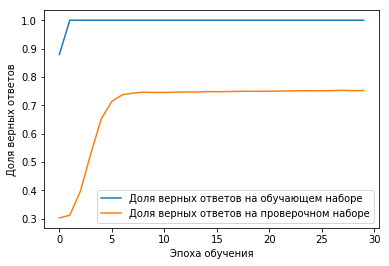

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(SpatialDropout1D(0.25))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.25))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=200,
                    validation_data=(xTest, yTest))


plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
 
  for i in range(nClasses):
    
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    currOut = np.argmax(currPred, axis=1)
    
    
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
   
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
   
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
 
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
    
  print()
  
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  96 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  38 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  69 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  35 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  88 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  98 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  75 %

